In [ ]:
import tensorflow

In [ ]:
import numpy as np
import pandas as pd
from numpy import random
from numpy.linalg import inv
import os
import scipy
from scipy import stats
from scipy.stats import skew,kurtosis
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import weightstats as ssw
import statsmodels.stats.multicomp
from statsmodels.stats import proportion as ssp
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
df=pd.read_csv(r"/content/aligned_stock_data.csv")
df.head()

,Date,Symbol,Open,High,Low,Close,Volume
0,08-01-1998,AAPL,0.131018,0.139940,0.127261,0.136652,774020800
1,09-01-1998,AAPL,0.136183,0.145575,0.131487,0.136652,886547200
2,12-01-1998,AAPL,0.131017,0.139940,0.128670,0.137122,516398400
3,13-01-1998,AAPL,0.139940,0.147453,0.139001,0.146514,636854400
4,14-01-1998,AAPL,0.149331,0.149801,0.144636,0.148392,589265600


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks

Data tools (pandas, numpy)

Plotting tools (matplotlib)

Data‑scaling tool (StandardScaler)

Evaluation metrics

Deep‑learning framework (TensorFlow/Keras)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")   # day‑month‑year
df = df.sort_values(['Date', 'Symbol']).reset_index(drop=True)


Load your stock data from a CSV file.

Convert the "Date" column to proper datetime format so it can be sorted and used in time-based models like LSTM.

Sort the dataset by Date and Symbol so that each stock's prices are in the correct order over time.

In [ ]:
# 2. BASIC TECHNICAL FEATURES
df['High_Low']     = df['High'] - df['Low']
df['Daily_Return'] = df.groupby('Symbol')['Close'].pct_change()
for w in [5, 10, 20]:
    df[f"MA{w}"] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(w).mean())

These are new columns/features that help the model understand market behavior:

High_Low: Measures the daily price range.

Daily_Return: How much price changed from the previous day.

MA5, MA10, MA20: Moving averages over 5, 10, and 20 days — helps the model learn trends (upward/downward movement).



In [ ]:
# TARGET = Tomorrow's Close
df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
df = df.dropna().reset_index(drop=True)

You want to predict the next day's closing price, so we shift the "Close" column by one step.

Rows with NaN values are removed (mainly last day of each symbol).



In [ ]:
# 3. ONE‑HOT ENCODE SYMBOL
df = pd.get_dummies(df, columns=['Symbol'], prefix='Sym', dtype='uint8')

Symbol is a category (like "TCS", "INFY", "RELIANCE").

Neural networks work better with numbers, so we convert each symbol into separate 0/1 columns.

This helps the model know which stock the data belongs to.

In [ ]:
# 4. SELECT FEATURES
num_cols = ['Open','High','Low','Close','Volume',
            'High_Low','Daily_Return','MA5','MA10','MA20']
sym_cols = [c for c in df.columns if c.startswith('Sym_')]
feature_cols = num_cols + sym_cols

 Tell the model which columns to use as input features.

This combines both the numeric and the stock-symbol dummy variables.

In [ ]:
# 5. SCALE ONLY NUMERIC FEATURES (keep dummies 0/1)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


Neural networks train faster and better when all inputs are on a similar scale.

StandardScaler changes values so that they are centered around 0 with a standard deviation of 1.

In [ ]:
# 6. BUILD SEQUENCES PER STOCK
LOOK_BACK = 20
X_list, y_list, date_list = [], [], []

for sym in df[sym_cols].idxmax(axis=1).unique():      # iterate symbols
    df_sym = df[df[sym] == 1]                         # rows for this symbol
    if len(df_sym) <= LOOK_BACK:                      # skip tiny series
        continue
    X_sym = df_sym[feature_cols].values
    y_sym = df_sym['Next_Close'].values
    dates = df_sym['Date'].values

    for i in range(LOOK_BACK, len(df_sym)):
        X_list.append(X_sym[i-LOOK_BACK:i])
        y_list.append(y_sym[i])
        date_list.append(dates[i])                    # date of prediction

X_all = np.array(X_list); y_all = np.array(y_list); dates_all = np.array(date_list)
print("Total windows:", X_all.shape)

Total windows: (305824, 20, 64)


LOOK_BACK = 20 means each training example will contain the last 20 days of data.

X_list, y_list, date_list are empty lists where we will collect our input sequences, their targets, and the date associated with each prediction.


df[sym_cols].idxmax(axis=1) finds which symbol column has a “1” in each row, then .unique() gets a list of all symbols.

df_sym filters rows for just one stock at a time.

If that stock has fewer than 20 rows of history, it’s too short for a 20‑day window, so we skip it.


Purpose:
Create sequences stock‑by‑stock so we preserve each stock’s internal order and don’t mix symbols inside a window.


X_sym: matrix of all chosen features for this stock.

y_sym: array of the target (Next_Close) for this stock.

dates: array of dates to keep track of which day each prediction belongs to.
Slides a moving window of length 20 across the stock’s timeline.

For each position i, it collects the previous 20 days (i‑LOOK_BACK : i) as one input sample and the price on day i as the label to predict.

Saves the corresponding date for later sorting.

Converts the Python lists into efficient NumPy arrays for model training.

X_all.shape prints something like (n_samples, 20, n_features) so you can see how many training windows you created in total.

In [ ]:
# 7. ORDER SEQUENCES CHRONOLOGICALLY  (so split is time‑based)
idx_sort = dates_all.argsort()
X_all, y_all = X_all[idx_sort], y_all[idx_sort]

dates_all.argsort() returns the index positions that would sort the dates_all array from oldest to newest.

Using those indices (idx_sort), we rearrange X_all and y_all so the input sequences and their labels are now in perfect date order.

sort every training window by its actual calendar date so that future data never sneaks into the past when we train the LSTM.”


In [ ]:
# 8. TRAIN / TEST SPLIT (80 % oldest → train)
split = int(len(X_all)*0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

print("Train windows:", X_train.shape, "| Test windows:", X_test.shape)


Train windows: (244659, 20, 64) | Test windows: (61165, 20, 64)


We train the LSTM on the first 80 % of days and check if it can predict the last 20 % of days that it has never seen.”

In [ ]:
# 9. BUILD & TRAIN LSTM
tf.keras.backend.clear_session()
model = Sequential([
    layers.Input(shape=(LOOK_BACK, X_train.shape[2])),  # (20 time steps, n_features)
    layers.LSTM(64, return_sequences=False), # main memory layer
    layers.Dropout(0.2),  # prevents overfitting
    layers.Dense(64, activation='relu'),  # extra learning capacity
    layers.Dense(1)  # single number output
])
model.compile(optimizer='adam', loss='mae')

early = callbacks.EarlyStopping(patience=3, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=20, # max training cycles
    batch_size=256,  # 256 samples per gradient update
    validation_split=0.1, # 10 % of training data held out for early‑stop check
    callbacks=[early], # apply early stopping
    verbose=1 # print progress
)

Epoch 1/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - loss: 13.7775 - val_loss: 7.0791
Epoch 2/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - loss: 2.1154 - val_loss: 4.7702
Epoch 3/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - loss: 1.7881 - val_loss: 4.5179
Epoch 4/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 84s 55ms/step - loss: 1.6653 - val_loss: 4.1206
Epoch 5/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - loss: 1.5681 - val_loss: 4.6479
Epoch 6/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - loss: 1.5231 - val_loss: 3.2124
Epoch 7/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 83s 54ms/step - loss: 1.4805 - val_loss: 3.1856
Epoch 8/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - loss: 1.4281 - val_loss: 3.0591
Epoch 9/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - loss: 1.3839 - val_loss: 3.0438
Epoch 10/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - loss: 1.3442 - val_loss: 3.1836
Epoch 11/20
861/861 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - loss: 1.2944 - val_loss: 2.9786
Epoch 12/20
861/861 ━━━━━━━━━

Clears any old models from memory so you start fresh (avoids accidental layer stacking if the cell is re‑run).

Input layer: tells Keras each sample has 20 past days (LOOK_BACK) and n_features columns.

LSTM(64): learns patterns across those 20 days using 64 memory units.

Dropout(0.2): randomly turns off 20 % of neurons each training step to stop overfitting.

Dense(64, relu): extra fully‑connected layer to combine features in a non‑linear way.

Dense(1): outputs one predicted price (next day’s close).

Adam optimizer: automatically adjusts learning rate, trains fast and reliably.

Loss = MAE (Mean Absolute Error): fits the model to minimise the average rupee error—easy to interpret.


Stops training once the validation error stops improving, saving time and preventing overfitting.


Training setup:

Up to 20 epochs, but may end sooner due to early stopping.

Batch size 256 speeds training on CPU/GPU.

10 % validation split gives a mini “test” inside training to monitor overfitting.





In [ ]:
# 10. PREDICT & METRICS
y_pred = model.predict(X_test).flatten()
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

1912/1912 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step


In [ ]:
rmse

np.float64(41.989638934344256)

In [ ]:
mae

9.678120305996439

In [ ]:
r2

0.9204559299671261

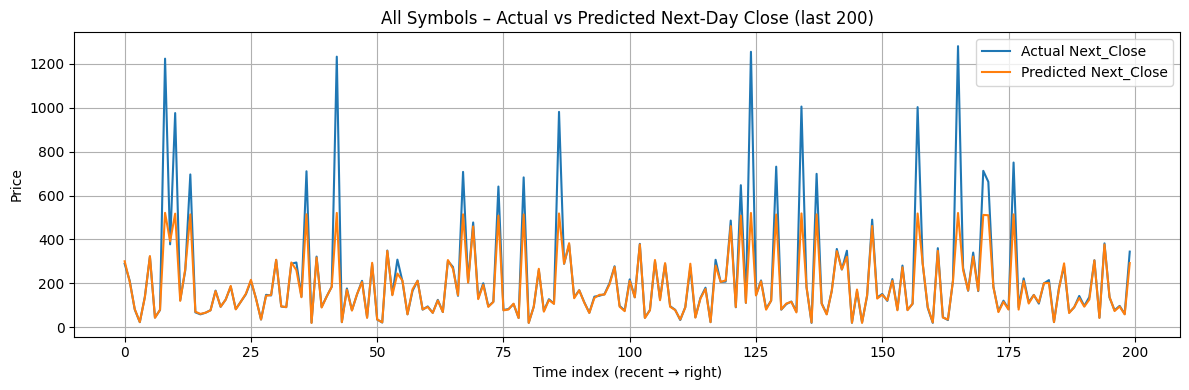

In [ ]:
# 11. PLOT (last 200 test points)
n = 200 if len(y_test) >= 200 else len(y_test)
plt.figure(figsize=(12,4))
plt.plot(range(n), y_test[-n:], label='Actual Next_Close')
plt.plot(range(n), y_pred[-n:], label='Predicted Next_Close')
plt.title(f"All Symbols – Actual vs Predicted Next‑Day Close (last {n})")
plt.xlabel("Time index (recent → right)"); plt.ylabel("Price")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()